In [2]:
import os

import keras.models
import numpy as np
from time import time
from scipy.io import wavfile as wav
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Import file
sound_rate, sound_data = wav.read('Datasets/UrbanSoundClassification/fold1/7061-6-0-0.wav')
# Play the signal
print(sound_rate)

44100


In [19]:
len(sound_data.shape)

2

In [ ]:
print([x[0] for x in sound_data])

### Zero crossing rage feature extraction

In [ ]:
def get_sign(number):
  if number <= 0:
    return -1
  else:
    return 1

def get_zero_crossing_rate(sound):
  total = len(sound)
  # zero_crossing_num = 0
  # for i in range(total - 1):
  #   current_value_sign = get_sign(sound[i])
  #   next_value_sign = get_sign(sound[i + 1])
  #   if current_value_sign != next_value_sign:
  #     zero_crossing_num += 1
  # result = np.array([zero_crossing_num / (total - 1)])
  # return result
  zero_crossings = librosa.zero_crossings(sound, pad=False)
  zcr_sum = np.sum(zero_crossings)
  result = np.array([zcr_sum / (total - 1)])
  return result


### Duration feature extraction

In [3]:
def duration(input):
    return np.array(input.shape)

### Energy feature extraction


In [23]:
# def root_mean_square_error(filename)

In [ ]:
# energia del segnale
def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

In [25]:
# def energy(input):
#     if np.sum((input*1.0)**2, keepdims=True).shape[0] != 1:
#         print(np.sum((input*1.0)**2, keepdims=True).shape)
#     energy_data = np.sum((input*1.0)**2, keepdims=True)
#     print(energy_data.shape)
#     if type(energy_data[0]) != 'numpy.ndarray':
#         return energy_data
#     else:
#         result = energy_data[0]
#         if type(result[0]) != 'numpy.ndarray':
#             return result
#         else:
#             while result.shape != (1,):
#                 result = result[0]
#             return result

In [26]:
# Import file
sound_rate, sound_data = wav.read('Datasets/UrbanSoundClassification/fold1/157867-8-0-6.wav')
# Play the signal
print(sound_rate)

44100


In [27]:
print(energy(sound_data).shape)

(1,)


### MFCCs features extraction

In [2]:
def feats_spectrogram(input, rate=2000, tsize=10):
    trimmed_input = feats_temporal(input, rate)
    X = librosa.stft(y=trimmed_input)
    Xdb = librosa.amplitude_to_db(abs(X))
    return Xdb.flatten()


def feats_mel(input, rate=2000, tsize=10):
    trimmed_input = feats_temporal(input, rate)
    X = librosa.feature.melspectrogram(y=trimmed_input, sr=rate)
    S_DB = librosa.power_to_db(X, ref=np.max)
    return S_DB.reshape(S_DB.shape[0] * S_DB.shape[1])


def feats_mfcc(input, rate=2000, tsize=10):
    trimmed_input = feats_temporal(input, rate)
    X = librosa.feature.mfcc(y=trimmed_input, sr=rate)
    return X.reshape(X.shape[0] * X.shape[1])

def feats_temporal(input, size=2000):
    # Remove any values exceeding the given limit
    output = input[0:min(size, input.shape[0])]
    # Add null values (padding) in order to reach the requested size
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output

# Feature extraction

In [2]:
def get_features(input, filename):
    try:
        return np.concatenate((energy(input), get_zero_crossing_rate(input), feats_spectrogram(input, 4000), feats_mel(input, 4000), feats_mfcc(input, 4000)))
    except Exception as e:
        print(e)


In [5]:
#data loading
from tqdm import tqdm
def load_data(feature_extractor=get_features, normalize=False):
    features = []
    labels = []
    x=0
    for f in os.listdir('Datasets/UrbanSoundClassification/'):
        for audio_file in tqdm(os.listdir('Datasets/UrbanSoundClassification/'+f)):
            try:
                if audio_file.endswith('.wav'):
                    _, signal = wav.read('Datasets/UrbanSoundClassification/'+f+'/'+audio_file)
                    if len(signal.shape) == 2:
                        signal = np.asarray([x[0] for x in signal])
                    file_features = get_features(signal, 'Datasets/UrbanSoundClassification/'+f+'/'+audio_file)
                    features.append(file_features)
                    label = audio_file.split('-')[1]
                    labels.append(label)
            except:
                None


    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)
    if normalize:
        eps = 0.001
        x_train = np.array(x_train)
        X_train_mean = x_train.mean(axis=0)
        X_train_std = x_train.std(axis=0)
        x_train = (x_train - X_train_mean + eps)/(X_train_std + eps)
        x_train = [row for row in x_train]

        x_test = [row for row in (np.array(x_test) - X_train_mean + eps)/(X_train_std + eps)]

    return x_train, x_test, y_train, y_test

In [6]:
x_train, x_test, y_train, y_test = load_data(normalize=True)

 50%|█████     | 439/873 [00:23<00:38, 11.37it/s]

In [32]:
len(x_train)

7850

In [9]:
np.savez_compressed('./Datasets/UrbanSoundClassification/processed', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

### Classification

In [4]:
dataset = np.load('./Datasets/UrbanSoundClassification/processed.npz', allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: './Datasets/UrbanSoundClassification/processed.npz'

In [4]:
x_train_list = [x.tolist() for x in dataset['x_train'] ]
y_train_list =   [x.tolist() for x in dataset['y_train'] ]

In [38]:
len(x_train_list)
len(y_train_list)
dataset['x_train'].shape
dataset['y_train'].shape

(7850,)

In [10]:
dataset['x_test'].shape


(873, 9386)

In [5]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(x_train_list, y_train_list)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 7639.468s


In [ ]:
import winsound
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

In [ ]:
import os
os.system("shutdown /s /t 1")


In [4]:
x_test_list = [x.tolist() for x in dataset['x_test'] ]
y_test_list = [x.tolist() for x in dataset['y_test'] ]

In [ ]:
import pickle

with open("./Datasets/Classifiers/speech/svm1.pickle", "wb+") as f:
    pickle.dump(clf, f)

In [11]:
import pickle

with open("./Datasets/Classifiers/speech/svm1.pickle", "rb") as f:
    svm_model = pickle.load(f)

In [12]:
y_pred = svm_model.predict(dataset['x_test'])
print(classification_report(y_test_list, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.84      0.88        96
           1       1.00      0.31      0.47        42
           2       0.69      0.58      0.63       100
           3       0.30      0.83      0.44        90
           4       0.84      0.64      0.73       106
           5       0.93      0.83      0.87       105
           6       1.00      0.33      0.50        33
           7       0.96      0.85      0.90       104
           8       0.94      0.67      0.78       100
           9       0.58      0.54      0.56        97

    accuracy                           0.69       873
   macro avg       0.82      0.64      0.68       873
weighted avg       0.80      0.69      0.71       873



Confusion matrix:


Text(0, 0.5, 'Prediction')

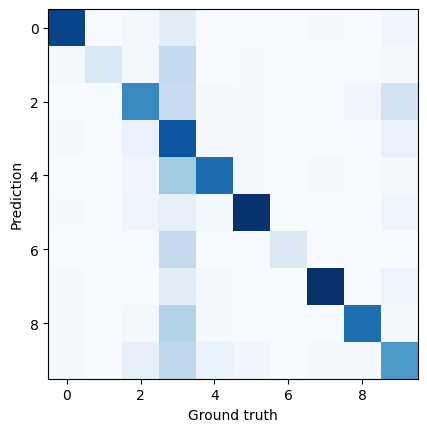

In [15]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test_list, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

### Multi layer perceptron

In [1]:
import os

import keras.models
import numpy as np
from time import time
from scipy.io import wavfile as wav
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
from keras.utils import to_categorical

one_hot_train = to_categorical(dataset['y_train'])
one_hot_test = to_categorical(dataset['y_test'])

NameError: name 'dataset' is not defined

In [13]:
def feats_temporal(input, size=2000):
    # Remove any values exceeding the given limit
    output = input[0:min(size, input.shape[0])]
    # Add null values (padding) in order to reach the requested size
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output
def feats_mfcc(input, rate=2000, tsize=10):
    trimmed_input = feats_temporal(input, rate)
    X = librosa.feature.mfcc(y=trimmed_input, sr=rate)
    return X


In [14]:
# data loading
from tqdm import tqdm


def get_features(input, filename):
    try:
        return np.array((feats_mfcc(input, 4000)))
    except Exception as e:
        print(e)

def load_data(feature_extractor=get_features, normalize=False):
    features = []
    labels = []
    x = 0
    for f in os.listdir('Datasets/UrbanSoundClassification/'):
        for audio_file in tqdm(os.listdir('Datasets/UrbanSoundClassification/'+f)):
            try:
                if audio_file.endswith('.wav'):
                    _, signal = wav.read(
                        'Datasets/UrbanSoundClassification/'+f+'/'+audio_file)
                    if len(signal.shape) == 2:
                        signal = np.asarray([x[0] for x in signal])
                    file_features = get_features(
                        signal, 'Datasets/UrbanSoundClassification/'+f+'/'+audio_file)
                    features.append(file_features)
                    label = audio_file.split('-')[1]
                    labels.append(label)
            except:
                None

    x_train, x_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.1, random_state=1)
    if normalize:
        eps = 0.001
        x_train = np.array(x_train)
        X_train_mean = x_train.mean(axis=0)
        X_train_std = x_train.std(axis=0)
        x_train = (x_train - X_train_mean + eps)/(X_train_std + eps)
        x_train = [row for row in x_train]

        x_test = [row for row in (
            np.array(x_test) - X_train_mean + eps)/(X_train_std + eps)]

    return x_train, x_test, y_train, y_test




In [15]:
x_train, x_test, y_train, y_test = load_data(normalize=False)


100%|██████████| 816/816 [00:46<00:00, 17.41it/s]


In [16]:
x_train[0].shape


(20, 8)

In [32]:
x_train = np.array(x_train).reshape(-1,x_train[0].shape[0],x_train[0].shape[1],1)
x_test = np.array(x_test).reshape(-1,x_test[0].shape[0],x_test[0].shape[1],1)

In [30]:
x_train[0].shape


(20, 8, 1)

In [52]:
from keras import regularizers, Input, Model
from keras.layers import Dense, Dropout, Conv2D,MaxPool2D, Flatten
reg = regularizers.l2(0.01)
input_layer = Input(shape=(20,8,1))
x = Conv2D(128, activation='relu', kernel_size=3, kernel_regularizer=reg)(input_layer)
x = MaxPool2D(pool_size=(2, 2))(x)
# x = Conv2D(32, activation='relu', kernel_size=3)(x)
# x = MaxPool2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(1024, activation='relu', kernel_regularizer=reg)(x)

x = Dense(512, activation='relu', kernel_regularizer=reg)(x)
# x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=reg)(x)
# x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=reg)(x)
x = Dropout(0.2)(x)
x = Dense(64, activation = 'relu', )(x)
x = Dropout(0.1)(x)
output = Dense(10, activation = "softmax")(x)

model = Model(input_layer, output)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 20, 8, 1)]        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 18, 6, 128)        1280      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 9, 3, 128)        0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 3456)              0         
                                                                 
 dense_49 (Dense)            (None, 1024)              3539968   
                                                                 
 dense_50 (Dense)            (None, 512)               524800    
                                                           

In [53]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
train_data = dataset['x_train']
test_data = dataset['x_test']
test_data.shape

NameError: name 'dataset' is not defined

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [37]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=1)


In [39]:
from keras.utils import to_categorical

one_hot_train = to_categorical(y_train)
one_hot_test = to_categorical(y_test)
one_hot_val = to_categorical(y_val)


In [54]:
import datetime
import tensorflow as tf
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks=[tensorboard_callback]

history = model.fit(x_train,one_hot_train , epochs=800, batch_size=64, validation_data=(x_val, one_hot_val))


Epoch 1/800
111/111 [==============================] - 1s 7ms/step - loss: 16.2574 - accuracy: 0.1271 - val_loss: 8.8415 - val_accuracy: 0.1669
Epoch 2/800
111/111 [==============================] - 1s 6ms/step - loss: 7.5068 - accuracy: 0.1656 - val_loss: 6.5540 - val_accuracy: 0.1987
Epoch 3/800
111/111 [==============================] - 1s 5ms/step - loss: 6.0128 - accuracy: 0.2301 - val_loss: 5.4844 - val_accuracy: 0.3045
Epoch 4/800
111/111 [==============================] - 1s 6ms/step - loss: 5.1948 - accuracy: 0.2793 - val_loss: 4.8678 - val_accuracy: 0.2968
Epoch 5/800
111/111 [==============================] - 1s 5ms/step - loss: 4.6189 - accuracy: 0.3244 - val_loss: 4.2901 - val_accuracy: 0.4025
Epoch 6/800
111/111 [==============================] - 1s 5ms/step - loss: 4.1565 - accuracy: 0.3650 - val_loss: 3.9054 - val_accuracy: 0.4166
Epoch 7/800
111/111 [==============================] - 1s 6ms/step - loss: 3.7810 - accuracy: 0.3892 - val_loss: 3.5794 - val_accuracy: 0.458

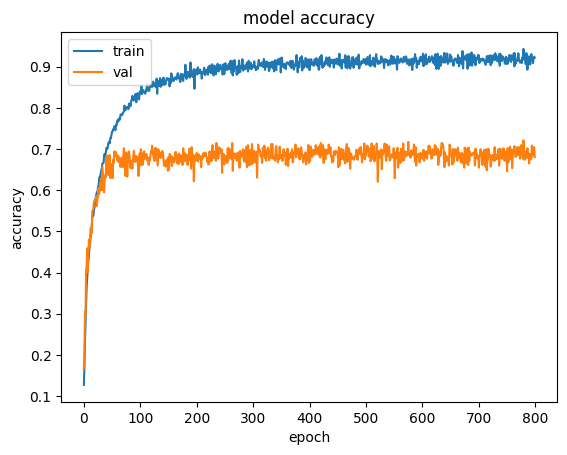

In [55]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [56]:
model.save('./Datasets/Classifiers/speech/mlp')

INFO:tensorflow:Assets written to: ./Datasets/Classifiers/speech/mlp\assets


INFO:tensorflow:Assets written to: ./Datasets/Classifiers/speech/mlp\assets


## Evaluation

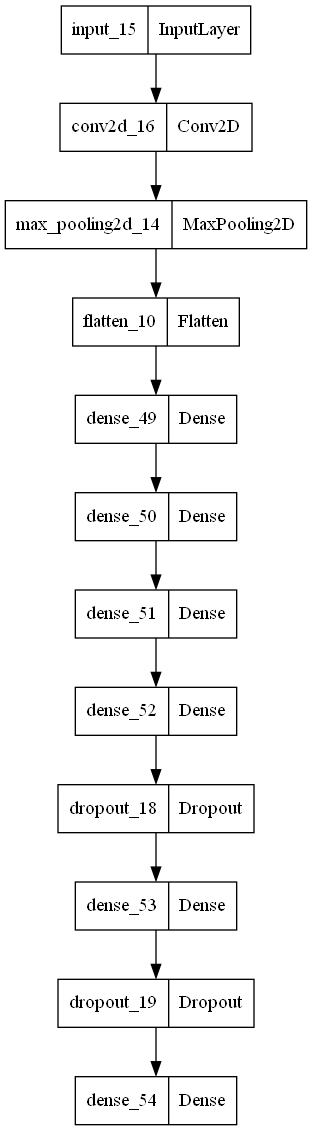

In [2]:
model = keras.models.load_model('./Datasets/Classifiers/speech/mlp')

keras.utils.plot_model(model, to_file='./cnnPlot.png')


In [3]:
model = keras.models.load_model('./Datasets/Classifiers/speech/mlp')
test_data = x_test
test_labels = [int(x) for x in y_test]

predictions = model.predict(test_data)
predicted_categories = np.argmax(predictions, axis=1)



NameError: name 'x_test' is not defined

In [ ]:
test_labels

Confusion matrix:


Text(0, 0.5, 'Prediction')

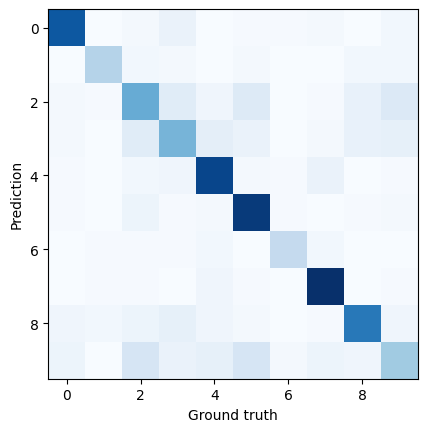

In [59]:

print('Confusion matrix:')
cm = confusion_matrix(test_labels, predicted_categories)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')


In [60]:
print(classification_report(test_labels, predicted_categories))


              precision    recall  f1-score   support

           0       0.84      0.84      0.84        96
           1       0.83      0.69      0.75        42
           2       0.51      0.49      0.50       100
           3       0.54      0.50      0.52        90
           4       0.72      0.83      0.77       106
           5       0.69      0.88      0.77       105
           6       0.83      0.73      0.77        33
           7       0.83      0.92      0.87       104
           8       0.76      0.69      0.72       100
           9       0.50      0.36      0.42        97

    accuracy                           0.70       873
   macro avg       0.70      0.69      0.69       873
weighted avg       0.69      0.70      0.69       873



### Demo

In [1]:
import pickle
import os

import keras.models
import numpy as np
from time import time
from scipy.io import wavfile as wav
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix


def get_sign(number):
  if number <= 0:
    return -1
  else:
    return 1

def get_zero_crossing_rate(sound):
  total = len(sound)
  zero_crossings = librosa.zero_crossings(sound, pad=False)
  zcr_sum = np.sum(zero_crossings)
  result = np.array([zcr_sum / (total - 1)])
  return result

def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

def feats_spectrogram(input, rate=2000, tsize=10):
    trimmed_input = feats_temporal(input, rate)
    X = librosa.stft(y=trimmed_input)
    Xdb = librosa.amplitude_to_db(abs(X))
    return Xdb.flatten()


def feats_mel(input, rate=2000, tsize=10):
    trimmed_input = feats_temporal(input, rate)
    X = librosa.feature.melspectrogram(y=trimmed_input, sr=rate)
    S_DB = librosa.power_to_db(X, ref=np.max)
    return S_DB.reshape(S_DB.shape[0] * S_DB.shape[1])


def feats_mfcc(input, rate=2000, tsize=10):
    trimmed_input = feats_temporal(input, rate)
    X = librosa.feature.mfcc(y=trimmed_input, sr=rate)
    return X.reshape(X.shape[0] * X.shape[1])


def feats_mfcc_mlp(input, rate=2000, tsize=10):
    trimmed_input = feats_temporal(input, rate)
    X = librosa.feature.mfcc(y=trimmed_input, sr=rate)
    return X

def feats_temporal(input, size=2000):
    # Remove any values exceeding the given limit
    output = input[0:min(size, input.shape[0])]
    # Add null values (padding) in order to reach the requested size
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output

def duration(input):
    return np.array(input.shape)


def get_features(input, filename):
    try:
        return np.concatenate((energy(input), get_zero_crossing_rate(input), feats_spectrogram(input, 4000), feats_mel(input, 4000), feats_mfcc(input, 4000)))
    except Exception as e:
        print(e)


def get_features_mlp(input, filename):
    try:
        return np.array( feats_mfcc_mlp(input, 4000))
    except Exception as e:
        print(e)


def make_classification(sound_path):
  #Load classifier
  with open('./Datasets/Classifiers/speech/svm1.pickle','rb') as f:
    svm_classifier = pickle.load(f)
  model = keras.models.load_model('./Datasets/Classifiers/speech/mlp')

  #Load sound
  _, signal = wav.read(sound_path)
  if len(signal.shape) == 2:
      signal = np.asarray([x[0] for x in signal])
  #Feature extraction
  feats = get_features(signal, sound_path)
  feats_mlp = get_features_mlp(signal, sound_path)
  feats_mlp = np.expand_dims(feats_mlp, axis=0).copy()
#   print(feats.shape)
  #classes
  classes = ['Air conditioner','Car horn', 'Children playing', 'Dog bark', 'Drilling', 'Engine idling', 'Gun shot', 'Jackhammer', 'Siren', 'Street music']
  #Result 
  res_svm = svm_classifier.predict([feats])
  res_mlp = model.predict([feats_mlp])
  index = np.argmax(res_mlp)
  #Print prediction
  print(f'The predicted class of the audio by svm is: {classes[int(res_svm[0])]}')
  print(f'The predicted class of the audio by mlp is: {classes[index]}')

  


In [2]:
#https://pixabay.com/sound-effects/search/dog 20barking/
make_classification('./dog_barking.wav')
make_classification('./jackhammer.wav')
make_classification('./dog_barking.wav')
make_classification('./air-conditioner.wav')


1/1 [==============================] - 5s 5s/step
The predicted class of the audio by svm is: Dog bark
The predicted class of the audio by mlp is: Drilling
1/1 [==============================] - 0s 89ms/step
The predicted class of the audio by svm is: Dog bark
The predicted class of the audio by mlp is: Dog bark
1/1 [==============================] - 0s 71ms/step
The predicted class of the audio by svm is: Dog bark
The predicted class of the audio by mlp is: Drilling
1/1 [==============================] - 0s 72ms/step
The predicted class of the audio by svm is: Dog bark
The predicted class of the audio by mlp is: Dog bark
